# Introduction

In this project, our **goal** is to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data.

## Datasets description

We was given two input datasets, one to train our model, and the second one to test our model predictions. <br /><br />
*Training data*
- The input data used for training in this project consists of two files. The first file, **train_time_series.csv**, contains the raw accelerometer data, which has been collected using the Beiwe research platform, and it has the following format: **timestamp, UTC time, accuracy, x, y, z**

- The second file, **train_labels.csv**, contains the activity labels, and we'll be using these labels to train your model. Different activities have been numbered with integers. The following encoding is used: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. Because the accelerometers are sampled at high frequency, the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv.

*Testing data*
- The input data used for testing also consists of two files **test_time_series.csv** and **test_labels.csv** which both have the same structure as the training data. This file **test_labels.csv** only contains the time stamps needed for prediction, and we will need to augment this file by adding the corresponding class predictions (1,2,3,4)

## Key steps

1. Data Preprocessing (Data cleaning, Initial data transformation)

2. Data Visualization/analysis

3. Data Processing (Balancing data, Feature engineering)

4. Model training & evaluation (using accuracy)

5. Testing data classification 

# Methods

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
#import dataframes
time_series_df = pd.read_csv('Desktop/projet_badr/CSV_files/train_time_series.csv')
train_labels_df = pd.read_csv('Desktop/projet_badr/CSV_files/train_labels.csv')

In [ ]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3744 non-null   int64  
 1   timestamp   3744 non-null   int64  
 2   UTC time    3744 non-null   object 
 3   accuracy    3744 non-null   object 
 4   x           3744 non-null   float64
 5   y           3744 non-null   float64
 6   z           3744 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 204.9+ KB


## Data Preprocessing
- Droping the unecessary columns.
- Merging the train_time_series and the train_labels dataframes based on the timestamps, and since the training labels contain labels for every 10 observations, I decided to fill the missing ones with the last label encountered

In [ ]:
#Droping the unecessary columns
time_series_df = time_series_df.drop(['Unnamed: 0'], 1)
train_labels_df = train_labels_df.drop(['Unnamed: 0'], 1)

In [ ]:
merged_df = pd.merge(time_series_df, train_labels_df, on='timestamp', how='outer') #merge the two dataframes
merged_df = merged_df.drop(['accuracy', 'UTC time_x', 'UTC time_y'], 1) #Droping the unecessary columns

merged_df = merged_df.fillna(method='ffill') #fill the missing ones with the last label encountered
merged_df = merged_df.fillna(method='bfill') # this one was only applied for the first missing labels in the dataframe and apply the next label encoutered

merged_df

,timestamp,x,y,z,label
0,1565109930787,-0.006485,-0.934860,-0.069046,1.0
1,1565109930887,-0.066467,-1.015442,0.089554,1.0
2,1565109930987,-0.043488,-1.021255,0.178467,1.0
3,1565109931087,-0.053802,-0.987701,0.068985,1.0
4,1565109931188,-0.054031,-1.003616,0.126450,1.0
...,...,...,...,...,...
3739,1565110305638,0.024384,-0.710709,0.030304,4.0
3740,1565110305738,0.487228,-1.099136,-0.015213,4.0
3741,1565110305838,0.369446,-0.968506,0.036713,4.0
3742,1565110305939,0.167877,-0.802826,0.049805,4.0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 0 to 3743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3744 non-null   int64  
 1   x          3744 non-null   float64
 2   y          3744 non-null   float64
 3   z          3744 non-null   float64
 4   label      3744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 175.5 KB


In [ ]:
#save the merged dataframe
#merged_df.to_csv('merged_df.csv', encoding='utf-8', index=False)

## Data Visualization 

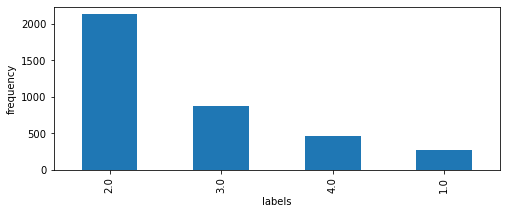

In [ ]:
#Check frequency of each label (to see if the dataset is imbalanced)
merged_df['label'].value_counts().plot(kind = 'bar', figsize=(8,3))
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

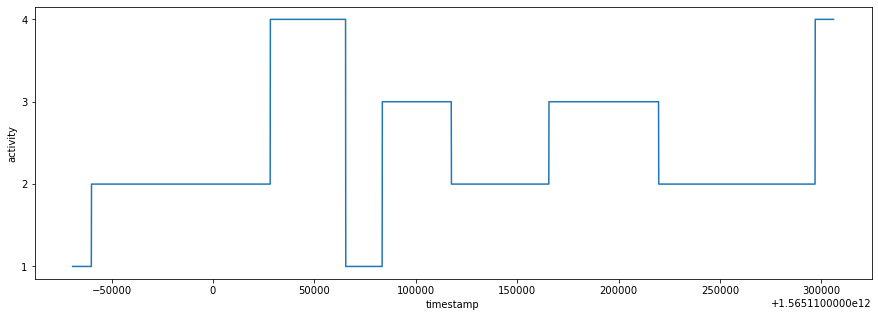

In [ ]:
#Check activities variation with time
fig = plt.figure(figsize=(15,5))
plt.xlabel("timestamp")
plt.ylabel("activity")
plt.plot(merged_df.timestamp, merged_df.label)
plt.yticks([1, 2, 3, 4])    
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

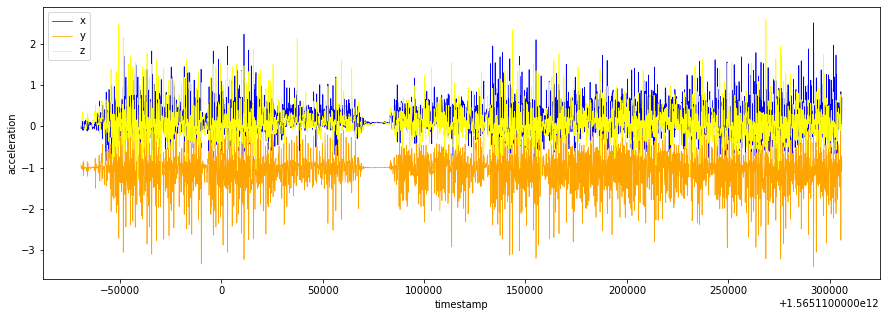

In [ ]:
#Check the variation of each linear acceleration with time
plt.figure(figsize=(15,5))
plt.plot(merged_df.timestamp, merged_df.x, linewidth=0.7, color='blue', label='x')
plt.plot(merged_df.timestamp, merged_df.y, linewidth=0.7, color='orange', label='y')
plt.plot(merged_df.timestamp, merged_df.z, linewidth=0.7, color='yellow', label='z')
plt.xlabel('timestamp')
plt.ylabel('acceleration')
plt.legend(loc='best');
plt.show

## Data processing
- Since the data visualization shows that the data is clearly unbalanced, I decided to try fixing the probleme by doing over-sampling.
- Doing feature engineering by adding a new Feature 'magnitude' to the dataframe, which represent the acceleration magnitude and is calculated using the different linear accelerations (formula : m = sqrt(x^2 + y^2 + z^2)). The goal of adding this feature is to give a better representation of our machine learning probleme to our model, and by doing so we can acheive better accuracy.

In [ ]:
#Adding magnitude column
merged_df['magnitude'] = np.sqrt(merged_df.x**2 + merged_df.y**2 + merged_df.z**2)
merged_df = merged_df[['timestamp', 'x', 'y', 'z', 'magnitude','label']] #reorder columns

In [ ]:
merged_df

,timestamp,x,y,z,magnitude,label
0,1565109930787,-0.006485,-0.934860,-0.069046,0.937429,1.0
1,1565109930887,-0.066467,-1.015442,0.089554,1.021548,1.0
2,1565109930987,-0.043488,-1.021255,0.178467,1.037644,1.0
3,1565109931087,-0.053802,-0.987701,0.068985,0.991568,1.0
4,1565109931188,-0.054031,-1.003616,0.126450,1.012993,1.0
...,...,...,...,...,...,...
3739,1565110305638,0.024384,-0.710709,0.030304,0.711772,4.0
3740,1565110305738,0.487228,-1.099136,-0.015213,1.202382,4.0
3741,1565110305838,0.369446,-0.968506,0.036713,1.037228,4.0
3742,1565110305939,0.167877,-0.802826,0.049805,0.821701,4.0


before oversampling:


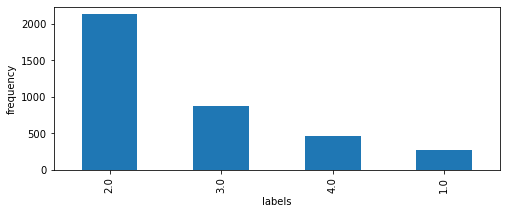

After oversampling:


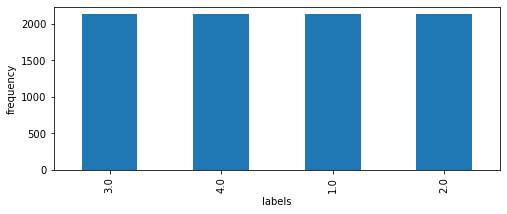

In [ ]:
# Balancing the dataframe (by oversampling)
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

print('before oversampling:')
merged_df['label'].value_counts().plot(kind = 'bar', figsize=(8,3))
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

merged_df = oversample(merged_df)

print('After oversampling:')
merged_df['label'].value_counts().plot(kind = 'bar', figsize=(8,3))
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

## Stratified K-fold cross validation
- I decided to use the Stratified K-fold cross validation to test and train my models since it give us a better scheme, both in terms of bias and variance, when compared to regular cross-validation. (It also gave me better results in terms of accuracy compared to when I only used standard K-fold cross validation)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [ ]:
target = merged_df.loc[:,'label']

In [ ]:
k = 5 #number of folds used with skf
skf = StratifiedKFold(n_splits=k)

In [ ]:
def train_model(train, test, fold_no, model):
    X = ['x', 'y', 'z', 'magnitude']
    y = ['label']
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    #print('Fold',str(fold_no),'Accuracy:',accuracy_score(y_test,predictions))
    return accuracy_score(y_test,predictions)

### Decision Tree

In [ ]:
DT_model = DecisionTreeClassifier()

acc_score = []
fold_no = 1
for train_index, test_index in skf.split(merged_df, target):
    train = merged_df.loc[train_index,:]
    test = merged_df.loc[test_index,:]
    acc_score.append(train_model(train,test,fold_no, DT_model))
    fold_no += 1
    
avg_acc_score = sum(acc_score)/k #Average accuracy of all folds
print('Average accuracy : {}\n'.format(avg_acc_score))

Average accuracy : 0.8738262910798122



### Random forest

In [ ]:
RF_model = RandomForestClassifier()

acc_score = []
fold_no = 1
for train_index, test_index in skf.split(merged_df, target):
    train = merged_df.loc[train_index,:]
    test = merged_df.loc[test_index,:]
    acc_score.append(train_model(train,test,fold_no, RF_model))
    fold_no += 1
    
avg_acc_score = sum(acc_score)/k #Average accuracy of all folds
print('Average accuracy : {}\n'.format(avg_acc_score))

Average accuracy : 0.89037558685446



### KNeighborsClassifier

In [ ]:
KN_model = KNeighborsClassifier(n_neighbors=4)

acc_score = []
fold_no = 1
for train_index, test_index in skf.split(merged_df, target):
    train = merged_df.loc[train_index,:]
    test = merged_df.loc[test_index,:]
    acc_score.append(train_model(train,test,fold_no, KN_model))
    fold_no += 1
    
avg_acc_score = sum(acc_score)/k #Average accuracy of all folds
print('Average accuracy : {}\n'.format(avg_acc_score))

Average accuracy : 0.7570422535211268



## Testing classification

Since The Random Forest model gave us the best result in term of accuracy, it will be the one we will apply to predict activities on the test data 

In [ ]:
start_time = time.process_time()

#import test dataframes
test_time_series_df = pd.read_csv('Desktop/projet_othman/CSV_files/test_time_series.csv')
test_labels_df = pd.read_csv('Desktop/projet_othman/CSV_files/test_labels.csv')

#Preprocessing 
test_time_series_df = test_time_series_df.drop(['Unnamed: 0'], 1)
test_labels_df = test_labels_df.drop(['Unnamed: 0'], 1)

test_merged_df = pd.merge(test_time_series_df, test_labels_df, on='timestamp', how='inner') #merging test dataframes
test_merged_df = test_merged_df.drop(['accuracy', 'UTC time_x', 'UTC time_y', 'label'], 1)
test_merged_df.shape

#Processing 
test_merged_df['magnitude'] = np.sqrt(test_merged_df.x**2 + test_merged_df.y**2 + test_merged_df.z**2) #adding magnitude column
test_merged_df = test_merged_df[['timestamp', 'x', 'y', 'z', 'magnitude']] #reorder columns

# Testing model prediction
test_merged_df['label'] = RF_model.predict(test_merged_df[['x', 'y', 'z', 'magnitude']])

end_time = time.process_time()
print('prediction time: ', end_time - start_time, ' seconds \n\n')

print(test_merged_df, '\n\n')




prediction time:  0.0323430000000009  seconds 


         timestamp         x         y         z  magnitude  label
0    1565110307041  0.098282 -0.833771  0.118042   0.847801    4.0
1    1565110308043  0.348465 -0.946701 -0.051041   1.010087    3.0
2    1565110309046  0.377335 -0.849243 -0.026474   0.929675    2.0
3    1565110310048  0.110077 -0.520325  0.312714   0.616964    3.0
4    1565110311050  0.283478 -0.892548 -0.085876   0.940412    4.0
..             ...       ...       ...       ...        ...    ...
120  1565110427366 -0.043915 -0.242416  0.068802   0.255789    3.0
121  1565110428369  0.118271 -1.212097  0.357468   1.269232    2.0
122  1565110429371  0.667404 -0.978851  0.171906   1.197134    2.0
123  1565110430373  0.371384 -1.021927 -0.244446   1.114457    2.0
124  1565110431376 -0.089462 -0.734573 -0.100876   0.746845    2.0

[125 rows x 6 columns] 




In [ ]:
#adding predicted labels to our test_label.csv file
test_label2 = test_merged_df[['timestamp', 'label']]
test_labels_df = test_labels_df.drop(['label'], 1)
test_labels_df = pd.merge(test_labels_df, test_label2, on='timestamp', how='inner')
print(test_labels_df)

         timestamp                 UTC time  label
0    1565110307041  2019-08-06T16:51:47.041    4.0
1    1565110308043  2019-08-06T16:51:48.043    3.0
2    1565110309046  2019-08-06T16:51:49.046    2.0
3    1565110310048  2019-08-06T16:51:50.048    3.0
4    1565110311050  2019-08-06T16:51:51.050    4.0
..             ...                      ...    ...
120  1565110427366  2019-08-06T16:53:47.366    3.0
121  1565110428369  2019-08-06T16:53:48.369    2.0
122  1565110429371  2019-08-06T16:53:49.371    2.0
123  1565110430373  2019-08-06T16:53:50.373    2.0
124  1565110431376  2019-08-06T16:53:51.376    2.0

[125 rows x 3 columns]


In [ ]:
#Saving the new augmented test_label.csv files
test_labels_df.to_csv('final_test_label.csv', sep='\t')

# Conclusion

I think we reached a pretty good accuracy (89%) combining the Random Forest classification model and the Stratified k-fold cross validation method. But we still can acheive better results by doing feature engineering and also spending some time tunning our Random Forest model.